In [1]:
!nvidia-smi

Fri Mar 26 19:46:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:19:00.0 Off |                  N/A |
|  0%   55C    P5   142W / 350W |      1MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb
!wandb login ee9416edde558c322450d0ec80266d2c0db81f45

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
%load_ext autoreload
%autoreload 2

In [12]:
import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [20]:
'''
import gdown
url = 'https://drive.google.com/uc?id=1p8YKs8uczGWj8lmHVhak-bNTNxdXbKBb'
output = 'celeba.zip'
gdown.download(url, output, quiet=False)
'''

Downloading...
From: https://drive.google.com/uc?id=1p8YKs8uczGWj8lmHVhak-bNTNxdXbKBb
To: /workspace/celeba.zip
2.73GB [00:28, 95.5MB/s]


'celeba.zip'

In [21]:
%%bash

unzip -q ./celeba.zip
rm -r ./celeba/celeba/img_align_celeba
unzip -q ./celeba/celeba/img_align_celeba.zip
mv ./img_align_celeba ./celeba/celeba/img_align_celeba

In [26]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1./255.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.rand_like(tensor) * self.std + self.mean, -1., 1.)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

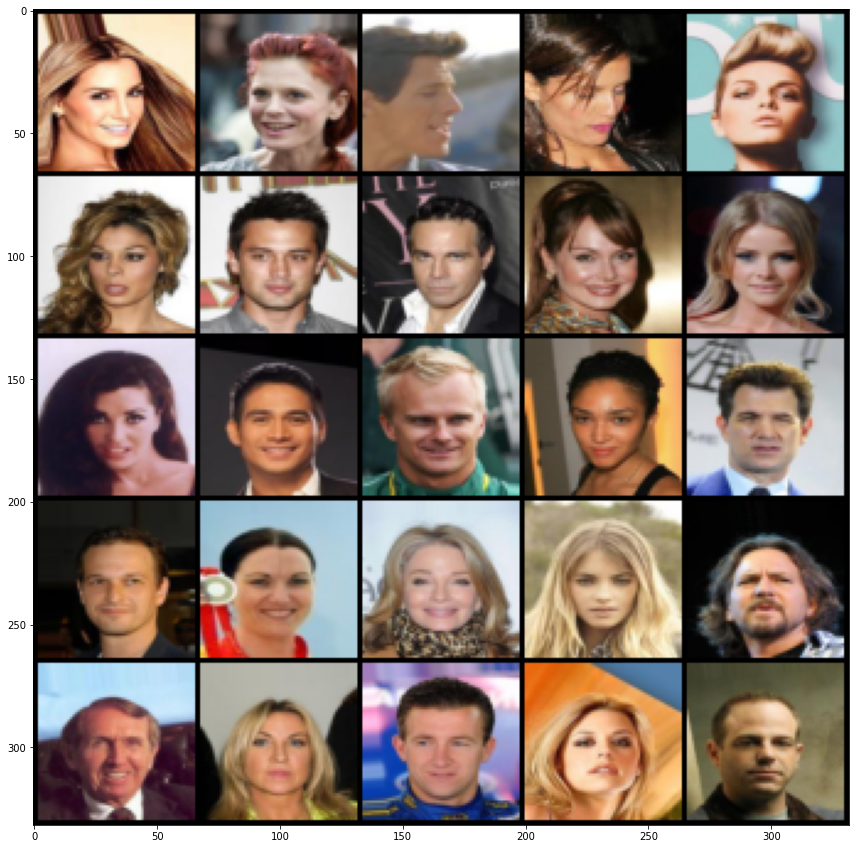

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip()
])
    
celeba_train = torchvision.datasets.CelebA('./celeba', target_type='attr', 
                                           transform=transforms, split="train", download=False)
celeba_val = torchvision.datasets.CelebA('./celeba', target_type='attr', 
                                         transform=transforms, split="valid", download=False)

plt.figure(figsize=(15,15))
plt.imshow(make_grid([celeba_train[i][0] for i in range(25)], nrow=5).permute(1,2,0)) #* 0.5 + 0.5)
plt.show()

In [14]:
import sys
from fid import calculate_fid, make_inception_feature_extractor
from vae import VAE
from glow import Glow
from vapnev import VAPNEV
from loss import VAELoss
from config import make_config
from utils import *

In [15]:
from math import log

def calc_loss(log_p, logdet, image_size, n_bins):
    n_pixel = image_size * image_size * 3
    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p
    log2 = log(2)
    return (
        (-loss / (log2 * n_pixel)).mean(),
        (log_p / (log2 * n_pixel)).mean(),
        (logdet / (log2 * n_pixel)).mean(),
    )


### Задача 1 (0.1 балла, но если не сделаете, за всю домашку ноль):

Для начала предлагаю попробовать обучить обычный VAE на Celeba до нормального качества, померить FID и запомнить для будущего сравнения


In [ ]:
SEED = 1992

seed_all(SEED)
config = make_config()
device = config.device
model = VAE(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
criterion = VAELoss(config.device)
classifier = make_inception_feature_extractor(device)
wandb.init(project='gen models hw3', name=f'VAE grad clip')
wandb.config.update(config)
torch.backends.cudnn.benchmark = True

celeba_train_dataloader = torch.utils.data.DataLoader(celeba_train, 
                                                      config.batch_size, 
                                                      shuffle=True, pin_memory=True, 
                                                      num_workers=2)
celeba_val_dataloader = torch.utils.data.DataLoader(celeba_val, 
                                                    config.batch_size, 
                                                    shuffle=False, drop_last=True,
                                                    pin_memory=True, num_workers=2)

In [ ]:
epochs = 15
log_step = 100

normalize = torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
for epoch in range(epochs):
    model.train()
    for step, (image, label) in enumerate(tqdm(celeba_train_dataloader, leave=False, desc=f"trainloop: {epoch}")):
        image = normalize(image)
        real_image = image.to(device)

        gen_image, mean, logvar = model(real_image)
        loss_dict, loss = criterion(gen_image, real_image, mean, logvar)
        wandb.log(loss_dict)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()

        if step % log_step == 0:   
            log_images(model, epoch, celeba_val_dataloader, device)

    log_images(model, epoch, celeba_val_dataloader, device)
    wandb.log({'fid': calculate_fid(celeba_val_dataloader, model, classifier, device)})
    torch.save({'E_state_dict': model.encoder.state_dict(), 
                'D_state_dict': model.decoder.state_dict(), 
                'optimizer': optimizer.state_dict()
               }, 'checkpoint.pt')

### Задача 2 (0.3 балла, но если не сделаете, за всю домашку max 0.1 за прошлый пункт):

После этого попробуем обучить обычный NF на Celeba до нормального качества, померить FID и запомнить для будущего сравнения

В качестве потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации. 

Можно использовать как и сверточные потоки, так и линейные (развернув селебу в один вектор)

In [27]:
import sys
import wandb

import torch
from torch import nn, optim
from glow import Glow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = make_config('Glow')

model = Glow(config)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
classifier = make_inception_feature_extractor(device)

wandb.init(project='gen models hw3', name=f'Glow, repo, affine=True')
wandb.watch(model)
wandb.config.update(config)
torch.backends.cudnn.benchmark = True

celeba_train_dataloader = torch.utils.data.DataLoader(celeba_train, 
                                                      config.batch, 
                                                      shuffle=True, pin_memory=True, 
                                                      num_workers=4)
celeba_val_dataloader = torch.utils.data.DataLoader(celeba_val, 
                                                    config.batch, 
                                                    shuffle=False, drop_last=True,
                                                    pin_memory=True, num_workers=4)



Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


wandb: Currently logged in as: arinaruck (use `wandb login --relogin` to force relogin)


In [ ]:
n_bins = 2.0 ** config.n_bits
epochs = 8

CHECKPOINT = '/glow_{}.pt'

with torch.no_grad():
    image, label = next(iter(celeba_train_dataloader))
    model.init_with_data(image)
    image = image.to(device)
    log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)

for epoch in range(epochs):
    for step, (image, label) in enumerate(tqdm(celeba_train_dataloader, 
                                               leave=False, desc=f"trainloop: {epoch}")):
        real_image = image
        image = image.to(device)
        image = image * 255

        if config.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - config.n_bits))

        image = image / n_bins - 0.5
        log_p, logdet, z_outs = model(image + torch.rand_like(image) / n_bins)
        logdet = logdet.mean()
        loss, log_p, log_det = calc_loss(log_p, logdet, config.img_size, n_bins)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({'loss': loss.item(), 'log_p': log_p.item(), 'log_det': log_det.item()})

        if step % 100 == 0:
            with torch.no_grad():
                real_image = real_image.numpy()
                fake_image = model.reverse(z_outs, reconstruct=True).cpu().numpy()
                sampled_image = model.sample(config.n_sample).cpu().numpy()
                total_steps = step + epoch * len(celeba_train_dataloader)
                wandb.log({'step': step,
                            'real images': [
                            wandb.Image(real_image[i].transpose(1, 2, 0), 
                                        caption=f"real, step: {total_steps}") 
                            for i in range(config.batch)],
                            'fake images': [
                            wandb.Image(fake_image[i].transpose(1, 2, 0), 
                                        caption=f"fake, step: {total_steps}") 
                            for i in range(config.batch)],
                          'sampled images': [
                            wandb.Image(sampled_image[i].transpose(1, 2, 0), 
                                        caption=f"sampled, step: {total_steps}") 
                            for i in range(config.n_sample)]})
        
    torch.save({'model_state_dict': model.state_dict(), 
                'optimizer': optimizer.state_dict()
               }, CHECKPOINT.format(epoch))
    wandb.log({'fid': calculate_fid(celeba_val_dataloader, model, classifier, device)})

## Задача 3 (0.6 балла):
Попробуйте повторить архитектуру VAPNEV из https://arxiv.org/pdf/1611.05209.pdf. Сравните качество (FID) между тремя разными моделями

Здесь вы можете использовать VAE и NF из предыдущих пунктов, необходимо только понять как они совмещаются в оригинальной статье

В отчете напишите, почему по вашему мнению такой подход будет лучше (или может быть хуже) чем обычный VAE?

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
import sys
import wandb

import torch
from torch import nn, optim
from vapnev import VAPNEV

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = make_config('vapnev')

model = VAPNEV(config)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=1e-4)
classifier = make_inception_feature_extractor(device)

print('full model:', count_parameters(model), 'encoder:', count_parameters(model.encoder), 'decoder:', 
      count_parameters(model.decoder), 'glow:', count_parameters(model.cond_glow))
wandb.init(project='gen models hw3', name=f'~VAPNEV')
wandb.watch(model)
wandb.config.update(config)
torch.backends.cudnn.benchmark = True

celeba_train_dataloader = torch.utils.data.DataLoader(celeba_train, 
                                                      config.batch_size, 
                                                      shuffle=True, pin_memory=True, 
                                                      num_workers=4)
celeba_val_dataloader = torch.utils.data.DataLoader(celeba_val, 
                                                    config.batch_size, 
                                                    shuffle=False, drop_last=True,
                                                    pin_memory=True, num_workers=4)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


full model: 99621539 encoder: 1945520 decoder: 77218371 glow: 20457648


wandb: Currently logged in as: arinaruck (use `wandb login --relogin` to force relogin)


In [ ]:
n_bins = 2.0 ** config.n_bits
epochs = 8

CHECKPOINT = '/vapnev_{}.pt'

for epoch in range(epochs):
    for step, (image, label) in enumerate(tqdm(celeba_train_dataloader, 
                                               leave=False, desc=f"trainloop: {epoch}")):
        real_image = image
        image = image.to(device)
        image = image * 255

        if config.n_bits < 8:
            image = torch.floor(image / 2 ** (8 - config.n_bits))

        image = image / n_bins - 0.5
        y, log_p, log_det = model(image + torch.rand_like(image) / n_bins)
        log_det = log_det.mean()
        loss, log_p, log_det = calc_loss(log_p, log_det, config.in_side, n_bins)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({'loss': loss.item(), 'log_p': log_p.item(), 'log_det': log_det.item()})

        if step % 100 == 0:
            with torch.no_grad():
                real_image = real_image.numpy()
                fake_image = model.reverse(image).cpu().numpy()
                print('fake', fake_image.min(), fake_image.max())
                sampled_image = model.sample(config.n_sample).cpu().numpy()
                print('sampled', sampled_image.min(), sampled_image.max())
                total_steps = step + epoch * len(celeba_train_dataloader)
                wandb.log({'step': step,
                            'real images': [
                            wandb.Image(real_image[i].transpose(1, 2, 0), 
                                        caption=f"real, step: {total_steps}") 
                            for i in range(config.batch_size)],
                           'fake images': [
                            wandb.Image(fake_image[i].transpose(1, 2, 0), 
                                        caption=f"fake, step: {total_steps}") 
                            for i in range(config.batch_size)],
                          'sampled images': [
                            wandb.Image(sampled_image[i].transpose(1, 2, 0), 
                                        caption=f"sampled, step: {total_steps}") 
                            for i in range(config.n_sample)]})
        
    torch.save({'model_state_dict': model.state_dict(), 
                'optimizer': optimizer.state_dict()
               }, CHECKPOINT.format(epoch))
    wandb.log({'fid': calculate_fid(celeba_val_dataloader, model, classifier, device)})